In [1]:
# Comparing using some data vs all data when not much has been collected yet.
# Goal is to choose between many sampled models or one model with many agents.

In [2]:
import multiprocessing 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import copy

import model_based_agent as mba 
import ensemble_mod_env as eme
import utils as ut
import tab_agents as tab

from datetime import datetime 

# 0. Find a decent set of smoothing parameters

In [3]:
dh = mba.DataHandler()
dh.load_df('ensemble_testing.pkl')

In [16]:
mod = eme.ModelSet(1,frac=1)
lambdas = [.1,.25,.5,.75,1]
iters = [5,10,20,30,50]
mods = {'body_on':[[] for _ in range(5)],
        'body_off':[[] for _ in range(5)],
        'head_on':[[] for _ in range(5)],
        'head_off':[[] for _ in range(5)],
        'reward_on':[[] for _ in range(5)],
        'reward_off':[[] for _ in range(5)],}
for i_l,l in enumerate(lambdas):  
    for it in iters:
        print(l,it)
        mod.make_models(dh,{'lambda':l,'iters':it})
        for key,item in mod.models[0].items():
            mods[key][i_l].append(item)

0.1 5
On model 0
0.1 10
On model 0
0.1 20
On model 0
0.1 30
On model 0
0.1 50
On model 0
0.25 5
On model 0
0.25 10
On model 0
0.25 20
On model 0
0.25 30
On model 0
0.25 50
On model 0
0.5 5
On model 0
0.5 10
On model 0
0.5 20
On model 0
0.5 30
On model 0
0.5 50
On model 0
0.75 5
On model 0
0.75 10
On model 0
0.75 20
On model 0
0.75 30
On model 0
0.75 50
On model 0
1 5
On model 0
1 10
On model 0
1 20
On model 0
1 30
On model 0
1 50
On model 0


In [17]:
def plot_key(mods,key,lambdas,iters):
    fig,ax = plt.subplots(len(lambdas),len(iters))
    fig.set_size_inches((12,12))
    for i_l,l in enumerate(lambdas):
        for i_it, it in enumerate(iters):
            img = ax[i_l,i_it].imshow(mods[key][i_l][i_it][:,:,0])
            fig.colorbar(img,ax=ax[i_l,i_it])
            ax[i_l,i_it].set_title(f'Lambda {l},Iters {it}')
            ax[i_l,i_it].axis('off')

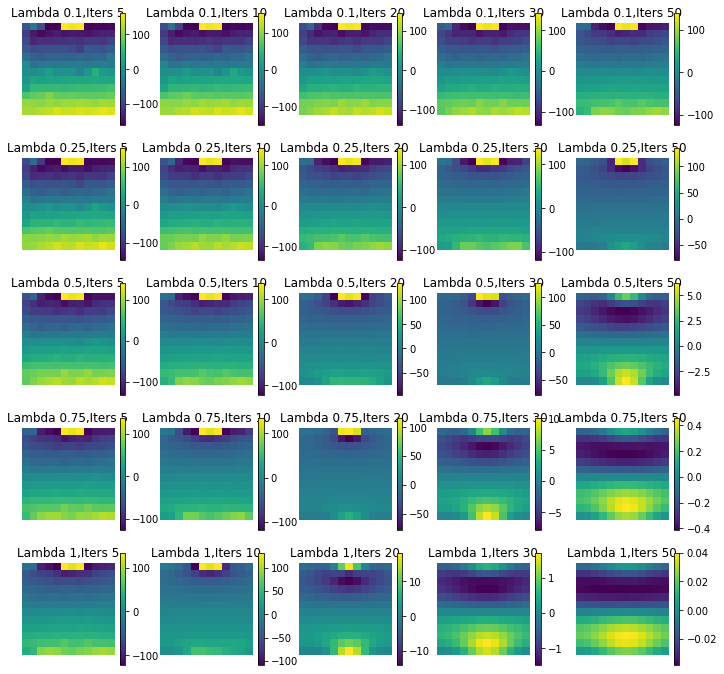

In [22]:
plot_key(mods,'body_on',lambdas,iters)

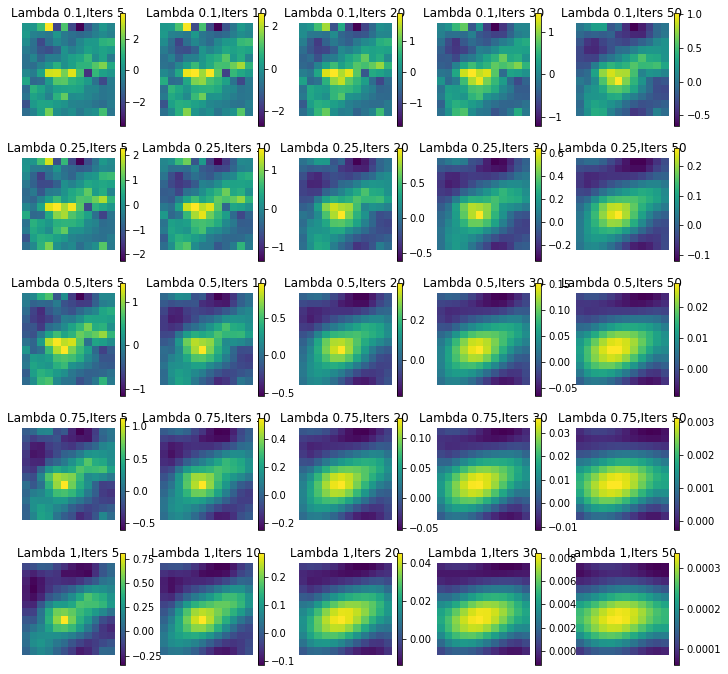

In [24]:
plot_key(mods,'reward_off',lambdas,iters)

# 1. Look at models w increasing amounts of data

In [ ]:
def mods_w_diff_samples(n_models,handler,samples):
    # Returns a list of models 
    mods = []
    for n in range(n_models):
        mods.append(eme.ModelSet(n_models,samples=samples))
        mods[n].make_models(handler,sm_pars={'lambda':.25,'iters':10})

# 2. Find out which learns faster: many sampled models or one main model.
Either way, uses lots of agents.
## 2.a. Many sampled models

## 2.b. One main model

In [16]:
def plot_qtabs(agt,vmin=None,vmax=None):
    fig,ax = plt.subplots(1,2)
    for i in range(2):
        img = ax[i].imshow(agt.Qtab[:,i].reshape(12,12),vmin=vmin,vmax=vmax)
        fig.colorbar(img,ax=ax[i])

In [18]:
num_learners = 5
collection_eps = 5

gamma=.25
epsilon=.05
alpha=.01
init_df = 'ensemble_testing.pkl'
qtabs = []

if __name__=='__main__':
    
    '''
    Runs parallel learners and joins them afterward
    '''

    worm_agent = tab.Q_Alpha_Agent(gamma=gamma, epsilon=epsilon, alpha=alpha) # Agent doesn't learn
    # Start model environments and learners 
    dh = mba.DataHandler()
    dh.load_df(init_df)
    dh.df = dh.df[:2000]
    
    for loop in range(collection_eps):        
        # Make new learner list based on newest data
        learners = mba.make_learner_list(num_learners, worm_pars={'num_models':1, 'frac':1},
                                gamma=gamma, epsilon=epsilon, alpha=alpha, q_checkpoint=worm_agent.Qtab)        
        
        # Start multiprocessing
        manager = multiprocessing.Manager()
        poison_queue = manager.Queue()
        pool = multiprocessing.Pool()
        
        # Run main functions: train agents and collect more data
        lea_outs = []
        print('learning')
        for lea in learners:
            lea_outs.append(pool.apply_async(lea.learn, [dh],{'learn_limit':1000}))
        # Wait for them to finish
        pool.close()
        pool.join()
        for lea_out in lea_outs:
            if lea_out.successful() is False:
                raise Exception('One learner failed')
        
        # Combining learners from run
        worm_agent.Qtab = mba.combine_learners(lea_outs)
        qtabs.append(worm_agent.Qtab.reshape((12,12,2)))

learning
learning
learning
learning
learning
